## Preparación de los datos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd


In [2]:
from os import scandir, getcwd

#Obtenemos la lista de las imágenes a redimensionar
def lsJPG(ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if (arch.is_file() and not arch.name.endswith('.2.jpg') 
                                                    and not arch.name.endswith('0.jpg') #no cargamos la img10
                                                    and arch.name.endswith('.jpg'))] #no segmentamos las de test

listImg = lsJPG("F:\Microplasticos\MuestrasPrueba (2,3,4-11-17)\Recortada\\2240x2240")
print(listImg)

['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']


In [3]:
#Lista con las imágenes ya segmentadas
n = int(2240/32) #70
listaRegiones = []
for img in listImg:
    recort = Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/"+img)
    for i in range(0,n):
        for j in range(0,n):
            subtring = img[0:-4]
            listaRegiones.append("imgID"+subtring+"-R"+str(i)+"C"+str(j))

len(listaRegiones)

44100

In [7]:
#Vamos a cargar el CSV con el Data Aug de la prueba pasada
def lsCSV(ruta = getcwd()):
    return[arch.name for arch in scandir(ruta) if (arch.is_file() and arch.name.endswith('.csv')
                                                   and arch.name.endswith('TODOS.csv'))]

listCSV = lsCSV("F:\Microplasticos\MuestrasPrueba (2,3,4-11-17)\Recortada\\2240x2240\CSV 32x32 Java")
csvTodos = listCSV[0]
print(csvTodos)

DatosImgTODOS.csv


In [9]:
dfTodos = pd.read_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV 32x32 Java/" + csvTodos)
unos = dfTodos[dfTodos['Plasticos'] == 1].count()
ceros = dfTodos[dfTodos['Plasticos'] == 0].count()

Nombre Segmento    25152
Plasticos          25152
dtype: int64
Nombre Segmento    40956
Plasticos          40956
dtype: int64


In [11]:
import random
unosList = dfTodos[dfTodos['Plasticos'] == 1]['Nombre Segmento'].tolist()
cerosList = dfTodos[dfTodos['Plasticos'] == 0]['Nombre Segmento'].tolist()
print("Imágenes con plásticos: ", len(unosList))
print("Imágenes sin plásticos: ", len(cerosList))

random.shuffle(cerosList)
random.shuffle(unosList)
cerosList = cerosList[:len(unosList)]
print("Ahora igualamos el nº de elementos: \ncerosList = ", len(cerosList))

Imágenes con plásticos:  25152
Imágenes sin plásticos:  40956
Ahora igualamos el nº de elementos: 
cerosList =  25152


In [12]:
from sklearn.model_selection import train_test_split
x = unosList + cerosList
y = np.concatenate([np.ones((len(unosList),),dtype=int),np.zeros((len(cerosList),),dtype=int)])
# Con stratify=y nos aseguramos que se mantenga la proporción 50% 50%
X_trainList, X_testList, Y_train, Y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, stratify=y)

In [22]:
#Guardamos las listas de los conjuntos de datos ya separados
dict1 = {'X_trainList': X_trainList, 'Y_train': Y_train} 
dict2 = {'X_testList': X_testList,'Y_test': Y_test}
dfTrain = pd.DataFrame(dict1)
dfTest = pd.DataFrame(dict2)
df = pd.concat([dfTrain, dfTest], axis=1) 
#Guardamos el DataFrame con el data augmentation
df.to_csv("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/CSV 32x32 Java/ConjuntoTrainTestTODOS.csv", header=True, index=False)
df.head()

,X_trainList,Y_train,X_testList,Y_test
0,imgID9-R58C44,0,imgID8-R52C40,0.0
1,imgIDf3-R59C26,1,imgID7-R45C32,0.0
2,imgIDc6-R30C43,1,imgIDa3-R35C41,1.0
3,imgIDd4-R49C53,1,imgID7-R48C53,1.0
4,imgIDf1-R38C49,1,imgID5-R65C17,0.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 4 columns):
X_trainList    35212 non-null object
Y_train        35212 non-null int32
X_testList     15092 non-null object
Y_test         15092 non-null float64
dtypes: float64(1), int32(1), object(2)
memory usage: 962.9+ KB


## Carga de datos para la red

In [13]:
#Array con todas las imágenes a entrenar
X_train = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas32x32/"+img + ".jpg")) for img in X_trainList] )
print(X_train.shape)
X_test = np.array([np.array(Image.open("MuestrasPrueba (2,3,4-11-17)/Recortada/2240x2240/Segmentadas32x32/"+img + ".jpg")) for img in X_testList] )
print(X_test.shape)

(35212, 32, 32, 3)
(15092, 32, 32, 3)


In [14]:
#Normalizamos la imagen
X_train= X_train / 255.0
X_test= X_test / 255.0
print(X_train.shape)
print(X_test.shape)

(35212, 32, 32, 3)
(15092, 32, 32, 3)


## Redes Neuronales


In [29]:
from keras.models                import Sequential, Model
from keras.layers                import Dense, Input, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.layers                import Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape, Activation, ReLU
from keras.preprocessing.image   import ImageDataGenerator
from keras.utils                 import to_categorical
from keras.optimizers            import SGD
from keras.callbacks             import ModelCheckpoint, LearningRateScheduler
from keras.utils                 import plot_model
import pydot
from sklearn.metrics             import confusion_matrix

In [30]:
def matrixConfusion (conf_mat, cmap, name):
    
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]),
            yticks=np.arange(conf_mat.shape[0]),
            xticklabels=["Arena","Plastico"], yticklabels=["Arena","Plastico"],
            title='Confusion matrix, normalizada',
            ylabel='True label',
            xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(name)
    
    plt.show()

### Prueba A

In [25]:
modelA = Sequential()
modelA.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelA.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelA.add(Activation('relu'))

modelA.add(Conv2D(64, (3, 3)))
modelA.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelA.add(Activation('relu'))

modelA.add(Flatten())  
modelA.add(Dense(128, activation='relu'))
modelA.add(Dense(64, activation='relu'))
modelA.add(Dropout(0.5))
modelA.add(Dense(1, activation='sigmoid'))
modelA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [28]:
plot_model(modelA, to_file='model_A.png', show_shapes=True, show_layer_names=True)

In [31]:
modelA_checkpoint = ModelCheckpoint('Pesos-ModelA.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
modelA.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelA_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 256s 7ms/step - loss: 0.2987 - acc: 0.8704 - val_loss: 0.2379 - val_acc: 0.9158

Epoch 00001: val_loss improved from inf to 0.23793, saving model to Segmentation32x32RedPesos.hdf5
Epoch 2/10
35212/35212 [==============================] - 57s 2ms/step - loss: 0.1818 - acc: 0.9373 - val_loss: 0.1595 - val_acc: 0.9424

Epoch 00002: val_loss improved from 0.23793 to 0.15951, saving model to Segmentation32x32RedPesos.hdf5
Epoch 3/10
35212/35212 [==============================] - 55s 2ms/step - loss: 0.1564 - acc: 0.9464 - val_loss: 0.1645 - val_acc: 0.9423

Epoch 00003: val_loss did not improve from 0.15951
Epoch 4/10
35212/35212 [==============================] - 57s 2ms/step - loss: 0.1428 - acc: 0.9519 - val_loss: 0.1786 - val_acc: 0.9378

Epoch 00004: val_loss did not improve from 0.15951
Epoch 5/10
35212/35212 [==============================] - 56s 2ms/step - loss: 0.1338 - acc: 

[[7092  454]
 [ 326 7220]]


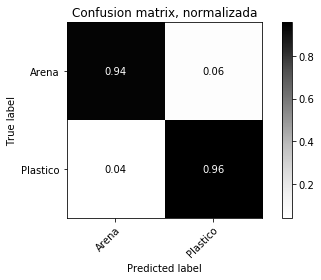

In [42]:
pv =  np.ravel(modelA.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
print(conf_mat)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelA.jpg")

### Prueba B

In [45]:
modelB = Sequential()
modelB.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelB.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelB.add(Activation('relu'))

modelB.add(Conv2D(64, (3, 3)))
modelB.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelB.add(Activation('relu'))

modelB.add(Flatten())  
modelB.add(Dense(128, activation='relu'))
modelB.add(Dropout(0.3))
modelB.add(Dense(64, activation='relu'))
modelB.add(Dropout(0.3))
modelB.add(Dense(32, activation='relu'))
modelB.add(Dropout(0.3))
modelB.add(Dense(1, activation='sigmoid'))
modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [46]:
plot_model(modelB, to_file='model_B.png', show_shapes=True, show_layer_names=True)
modelB_checkpoint = ModelCheckpoint('Pesos-ModelB.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [47]:
historyB = modelB.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelB_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 56s 2ms/step - loss: 0.3209 - acc: 0.8569 - val_loss: 0.2048 - val_acc: 0.9258

Epoch 00001: val_loss improved from inf to 0.20477, saving model to Pesos-ModelB.hdf5
Epoch 2/10
35212/35212 [==============================] - 58s 2ms/step - loss: 0.1888 - acc: 0.9326 - val_loss: 0.2260 - val_acc: 0.9225

Epoch 00002: val_loss did not improve from 0.20477
Epoch 3/10
35212/35212 [==============================] - 52s 1ms/step - loss: 0.1651 - acc: 0.9418 - val_loss: 0.1579 - val_acc: 0.9455

Epoch 00003: val_loss improved from 0.20477 to 0.15794, saving model to Pesos-ModelB.hdf5
Epoch 4/10
35212/35212 [==============================] - 55s 2ms/step - loss: 0.1476 - acc: 0.9504 - val_loss: 0.2861 - val_acc: 0.9197

Epoch 00004: val_loss did not improve from 0.15794
Epoch 5/10
35212/35212 [==============================] - 55s 2ms/step - loss: 0.1364 - acc: 0.9539 - val_loss: 0.1563 -

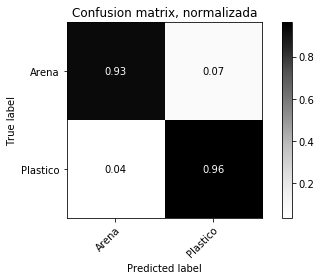

In [48]:
pv =  np.ravel(modelB.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelB.jpg")

### Prueba C


In [49]:
modelC = Sequential()
modelC.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelC.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelC.add(Activation('relu'))

modelC.add(Conv2D(64, (3, 3)))
modelC.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelC.add(Activation('relu'))

modelC.add(Conv2D(128, (3, 3)))
modelC.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelC.add(Activation('relu'))

modelC.add(Flatten())  
modelC.add(Dense(128, activation='relu'))
modelC.add(Dropout(0.3))
modelC.add(Dense(64, activation='relu'))
modelC.add(Dropout(0.3))
modelC.add(Dense(1, activation='sigmoid'))
modelC.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [50]:
plot_model(modelC, to_file='model_C.png', show_shapes=True, show_layer_names=True)
modelC_checkpoint = ModelCheckpoint('Pesos-ModelC.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [51]:
historyC = modelC.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelC_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 60s 2ms/step - loss: 0.2878 - acc: 0.8746 - val_loss: 0.1795 - val_acc: 0.9368

Epoch 00001: val_loss improved from inf to 0.17955, saving model to Pesos-ModelC.hdf5
Epoch 2/10
35212/35212 [==============================] - 62s 2ms/step - loss: 0.1785 - acc: 0.9370 - val_loss: 0.3057 - val_acc: 0.8886

Epoch 00002: val_loss did not improve from 0.17955
Epoch 3/10
35212/35212 [==============================] - 60s 2ms/step - loss: 0.1612 - acc: 0.9439 - val_loss: 0.1496 - val_acc: 0.9475

Epoch 00003: val_loss improved from 0.17955 to 0.14961, saving model to Pesos-ModelC.hdf5
Epoch 4/10
35212/35212 [==============================] - 72s 2ms/step - loss: 0.1475 - acc: 0.9490 - val_loss: 0.1818 - val_acc: 0.9327

Epoch 00004: val_loss did not improve from 0.14961
Epoch 5/10
35212/35212 [==============================] - 65s 2ms/step - loss: 0.1378 - acc: 0.9533 - val_loss: 0.1362 -

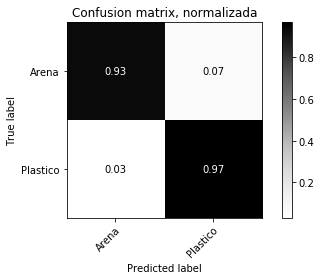

In [52]:
pv =  np.ravel(modelC.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelC.jpg")

### Prueba D

In [53]:
modelD = Sequential()
modelD.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelD.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelD.add(Activation('relu'))

modelD.add(Flatten())  
modelD.add(Dense(64, activation='relu'))
modelD.add(Dropout(0.3))
modelD.add(Dense(1, activation='sigmoid'))
modelD.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelD, to_file='model_D.png', show_shapes=True, show_layer_names=True)
modelD_checkpoint = ModelCheckpoint('Pesos-ModelD.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [54]:
historyD = modelD.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelD_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 35s 998us/step - loss: 0.3925 - acc: 0.8155 - val_loss: 0.2853 - val_acc: 0.8765

Epoch 00001: val_loss improved from inf to 0.28531, saving model to Pesos-ModelD.hdf5
Epoch 2/10
35212/35212 [==============================] - 56s 2ms/step - loss: 0.2669 - acc: 0.8963 - val_loss: 0.2439 - val_acc: 0.9113

Epoch 00002: val_loss improved from 0.28531 to 0.24388, saving model to Pesos-ModelD.hdf5
Epoch 3/10
35212/35212 [==============================] - 34s 976us/step - loss: 0.2423 - acc: 0.9084 - val_loss: 0.2329 - val_acc: 0.9087

Epoch 00003: val_loss improved from 0.24388 to 0.23293, saving model to Pesos-ModelD.hdf5
Epoch 4/10
35212/35212 [==============================] - 34s 969us/step - loss: 0.2284 - acc: 0.9157 - val_loss: 0.2243 - val_acc: 0.9190

Epoch 00004: val_loss improved from 0.23293 to 0.22434, saving model to Pesos-ModelD.hdf5
Epoch 5/10
35212/35212 [============

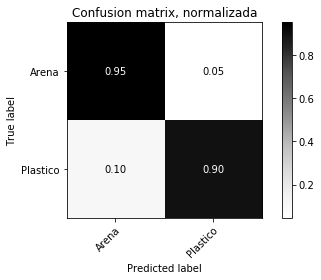

In [55]:
pv =  np.ravel(modelD.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelD.jpg")

### Prueba E

In [1]:
modelE = Sequential()
modelE.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelE.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelE.add(Activation('relu'))

modelE.add(Conv2D(32, (3, 3)))
modelE.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelE.add(Activation('relu'))

modelE.add(Conv2D(64, (3, 3)))
modelE.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelE.add(Activation('relu'))

modelE.add(Flatten())
modelE.add(Dense(64, activation='relu'))
modelE.add(Dropout(0.3))
modelE.add(Dense(32, activation='relu'))
modelE.add(Dropout(0.3))
modelE.add(Dense(1, activation='sigmoid'))
modelE.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelE, to_file='model_E.png', show_shapes=True, show_layer_names=True)
modelE_checkpoint = ModelCheckpoint('Pesos-ModelE.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

NameError: name 'Sequential' is not defined

In [58]:
historyE = modelE.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelE_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 77s 2ms/step - loss: 0.3223 - acc: 0.8538 - val_loss: 0.2335 - val_acc: 0.9206

Epoch 00001: val_loss improved from inf to 0.23349, saving model to Pesos-ModelE.hdf5
Epoch 2/10
35212/35212 [==============================] - 49s 1ms/step - loss: 0.2013 - acc: 0.9282 - val_loss: 0.1840 - val_acc: 0.9341

Epoch 00002: val_loss improved from 0.23349 to 0.18399, saving model to Pesos-ModelE.hdf5
Epoch 3/10
35212/35212 [==============================] - 49s 1ms/step - loss: 0.1811 - acc: 0.9358 - val_loss: 0.1946 - val_acc: 0.9291

Epoch 00003: val_loss did not improve from 0.18399
Epoch 4/10
35212/35212 [==============================] - 49s 1ms/step - loss: 0.1682 - acc: 0.9412 - val_loss: 0.1658 - val_acc: 0.9398

Epoch 00004: val_loss improved from 0.18399 to 0.16583, saving model to Pesos-ModelE.hdf5
Epoch 5/10
35212/35212 [==============================] - 47s 1ms/step - loss: 0.

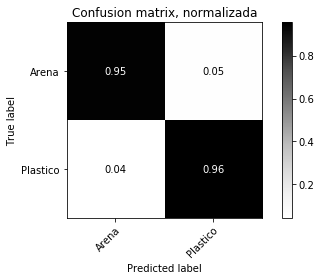

In [59]:
pv =  np.ravel(modelE.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelE.jpg")

### Prueba F

In [66]:
modelF = Sequential()
modelF.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelF.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelF.add(Activation('relu'))

modelF.add(Conv2D(32, (3, 3)))
modelF.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelF.add(Activation('relu'))

modelF.add(Conv2D(64, (3, 3)))
modelF.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelF.add(Activation('relu'))

modelF.add(Flatten())  
modelF.add(Dense(64, activation='relu'))
modelF.add(Dropout(0.3))
modelF.add(Dense(32, activation='relu'))
modelC.add(Dropout(0.3))
modelF.add(Dense(1, activation='sigmoid'))
modelF.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelF, to_file='model_F.png', show_shapes=True, show_layer_names=True)
modelF_checkpoint = ModelCheckpoint('Pesos-ModelF.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [67]:
historyF = modelF.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelF_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 48s 1ms/step - loss: 0.3100 - acc: 0.8648 - val_loss: 0.1857 - val_acc: 0.9331

Epoch 00001: val_loss improved from inf to 0.18570, saving model to Pesos-ModelF.hdf5
Epoch 2/10
35212/35212 [==============================] - 46s 1ms/step - loss: 0.1854 - acc: 0.9340 - val_loss: 0.1731 - val_acc: 0.9333

Epoch 00002: val_loss improved from 0.18570 to 0.17306, saving model to Pesos-ModelF.hdf5
Epoch 3/10
35212/35212 [==============================] - 48s 1ms/step - loss: 0.1635 - acc: 0.9421 - val_loss: 0.1509 - val_acc: 0.9487

Epoch 00003: val_loss improved from 0.17306 to 0.15092, saving model to Pesos-ModelF.hdf5
Epoch 4/10
35212/35212 [==============================] - 46s 1ms/step - loss: 0.1553 - acc: 0.9459 - val_loss: 0.1522 - val_acc: 0.9471

Epoch 00004: val_loss did not improve from 0.15092
Epoch 5/10
35212/35212 [==============================] - 45s 1ms/step - loss: 0.

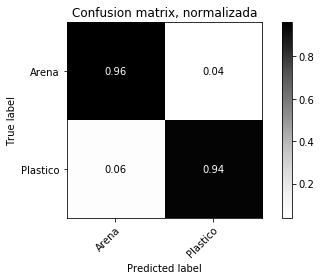

In [68]:
pv =  np.ravel(modelF.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelF.jpg")

### Prueba G

In [63]:
modelG = Sequential()
modelG.add(Conv2D(16, (3, 3), input_shape=(32, 32,3)))
modelG.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelG.add(Activation('relu'))

modelG.add(Conv2D(32, (3, 3)))
modelG.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelG.add(Activation('relu'))

modelG.add(Flatten())  
modelG.add(Dense(64, activation='relu'))
modelG.add(Dropout(0.3))
modelG.add(Dense(1, activation='sigmoid'))
modelG.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelG, to_file='model_G.png', show_shapes=True, show_layer_names=True)
modelG_checkpoint = ModelCheckpoint('Pesos-ModelG.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [64]:
historyG = modelG.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelG_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 51s 1ms/step - loss: 0.3398 - acc: 0.8476 - val_loss: 0.2286 - val_acc: 0.9176

Epoch 00001: val_loss improved from inf to 0.22864, saving model to Pesos-ModelG.hdf5
Epoch 2/10
35212/35212 [==============================] - 51s 1ms/step - loss: 0.2132 - acc: 0.9232 - val_loss: 0.1976 - val_acc: 0.9239

Epoch 00002: val_loss improved from 0.22864 to 0.19758, saving model to Pesos-ModelG.hdf5
Epoch 3/10
35212/35212 [==============================] - 51s 1ms/step - loss: 0.1830 - acc: 0.9339 - val_loss: 0.1888 - val_acc: 0.9259

Epoch 00003: val_loss improved from 0.19758 to 0.18879, saving model to Pesos-ModelG.hdf5
Epoch 4/10
35212/35212 [==============================] - 52s 1ms/step - loss: 0.1662 - acc: 0.9413 - val_loss: 0.1581 - val_acc: 0.9437

Epoch 00004: val_loss improved from 0.18879 to 0.15808, saving model to Pesos-ModelG.hdf5
Epoch 5/10
35212/35212 [==================

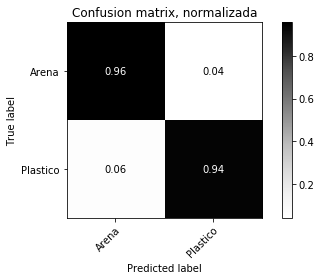

In [65]:
pv =  np.ravel(modelG.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelG.jpg")

### Prueba H

In [81]:
modelH = Sequential()
modelH.add(Conv2D(32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'))
modelH.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modelH.add(MaxPooling2D(pool_size=(2, 2)))
    
modelH.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
modelH.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

modelH.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
modelH.add(MaxPooling2D(pool_size=(2, 2)))
modelH.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
modelH.add(MaxPooling2D(pool_size=(2, 2)))

modelH.add(Flatten())  
modelH.add(Dense(256, activation='relu'))
modelH.add(Dropout(0.3))
modelH.add(Dense(64, activation='relu'))
modelH.add(Dropout(0.3))
modelH.add(Dense(1, activation='sigmoid'))
modelH.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelH, to_file='model_H.png', show_shapes=True, show_layer_names=True)
modelH_checkpoint = ModelCheckpoint('Pesos-ModelH.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

In [82]:
historyH = modelH.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelH_checkpoint])

Train on 35212 samples, validate on 15092 samples
Epoch 1/10
35212/35212 [==============================] - 1834s 52ms/step - loss: 0.7044 - acc: 0.5573 - val_loss: 7.9357 - val_acc: 0.5009

Epoch 00001: val_loss improved from inf to 7.93573, saving model to Pesos-ModelH.hdf5
Epoch 2/10
35212/35212 [==============================] - 1757s 50ms/step - loss: 7.9752 - acc: 0.4998 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 7.93573
Epoch 3/10
35212/35212 [==============================] - 1766s 50ms/step - loss: 7.9690 - acc: 0.5001 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 7.93573
Epoch 4/10
35212/35212 [==============================] - 1756s 50ms/step - loss: 7.9703 - acc: 0.5001 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 7.93573
Epoch 5/10
35212/35212 [==============================] - 1747s 50ms/step - loss: 7.9730 - acc: 0.4999 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 

KeyboardInterrupt: 

In [ ]:
pv =  np.ravel(modelH.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelH.jpg")

### Prueba K

In [72]:
modelK = Sequential()
modelK.add(Conv2D(32, (3, 3), input_shape=(32, 32,3)))
modelK.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelK.add(Activation('relu'))

modelK.add(Conv2D(64, (3, 3)))
modelK.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelK.add(Activation('relu'))

modelK.add(Conv2D(128, (3, 3)))
modelK.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelK.add(Activation('relu'))

modelK.add(Conv2D(256, (3, 3)))
modelK.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelK.add(Activation('relu'))

modelK.add(Conv2D(512, (3, 3)))
modelK.add(MaxPooling2D(pool_size=(2, 2))) #Comprimir la info y hacer que sea menos propensa a errores de traslaciones
modelK.add(Activation('relu'))

modelK.add(Flatten())  
modelK.add(Dense(512, activation='relu'))
modelK.add(Dropout(0.3))
modelK.add(Dense(128, activation='relu'))
modelK.add(Dropout(0.3))
modelK.add(Dense(32, activation='relu'))
modelK.add(Dropout(0.3))
modelK.add(Dense(1, activation='sigmoid'))
modelK.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

plot_model(modelK, to_file='model_K.png', show_shapes=True, show_layer_names=True)
modelH_checkpoint = ModelCheckpoint('Pesos-ModelK.hdf5', monitor='val_loss',verbose=1, save_best_only=True)

ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_41/convolution' (op: 'Conv2D') with input shapes: [?,2,2,128], [3,3,128,256].

In [ ]:
historyK = modelK.fit(X_train, Y_train,  batch_size=32, validation_data=[X_test, Y_test], epochs=10, callbacks=[modelK_checkpoint])

In [ ]:
pv =  np.ravel(modelK.predict(X_test))
pv_round = np.asarray([int(round(i)) for i in pv])
conf_mat = confusion_matrix(Y_test, pv_round)
matrixConfusion(conf_mat,'Greys',"MatrizConfusion-ModelK.jpg")